# Using scikit-learn implementation of Isolation Forest vs XGBoost to identify fraudulent banknotes in [UCI](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) dataset

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import pandas as pd

import hyperopt
import skopt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold 
from sklearn import metrics

In [2]:
data = pd.read_csv('data_banknote_authentication.txt', header=0)
print(data.head())

       var    skew    curt     entr  class
0  3.62160  8.6661 -2.8073 -0.44699      0
1  4.54590  8.1674 -2.4586 -1.46210      0
2  3.86600 -2.6383  1.9242  0.10645      0
3  3.45660  9.5228 -4.0112 -3.59440      0
4  0.32924 -4.4552  4.5718 -0.98880      0


In [12]:
data_no_class = data.drop('class', axis=1)
data0 = data[data['class'] == 0].drop('class', axis=1)
data1 = data[data['class'] == 1].drop('class', axis=1)

# data and target numpy arrays for cross-validation
data_arr = data_no_class.values
target_arr = data['class'].values


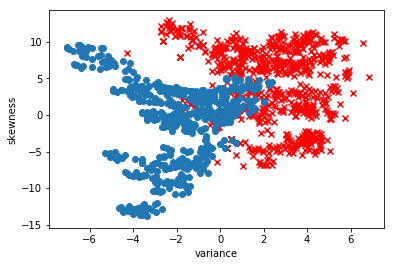

In [32]:
plt.scatter(data0.iloc[:,0], data0.iloc[:,1], marker = 'x', color='r')
plt.scatter(data1.iloc[:,0], data1.iloc[:,1], marker = 'o')
plt.xlabel('variance')
plt.ylabel('skewness')

In [8]:
# original class labels are 0 and 1, IsolationForest returns 1 for inliers and -1 for outliers
def to_class(a):
    return np.array([0 if x == 1 else 1 for x in np.nditer(a)])

# hyperparameter optimization objective function
def forest_loss(x):   
    losses = []
    cv = KFold(n_splits=3)
    for i_train, i_test in cv.split(data_arr):
        train_data, test_data = data_arr[i_train], data_arr[i_test]
        
        forest = IsolationForest(contamination=x[0], n_estimators=100, max_features=data0.shape[1], 
                                 bootstrap=True, n_jobs=1, verbose=0)        
        forest.fit(data_arr[train_data['class'] == 0])
        
        pred_class = to_class(forest.predict(test_data))
        actual_class = data['class'].values[i_test]
        
        losses.append(-1 * metrics.accuracy_score(pred_class, actual_class, normalize=True)) 
    
    return np.array(losses).mean()

In [9]:
# hyperparameter optimization using skopt library
skopt_min = skopt.gp_minimize(forest_loss, 
                              [(0.05, 0.9)], 
                              n_calls=100,
                              n_random_starts=10)

argmin: [0.18536642464292685]
f_min: -0.8695801044085374


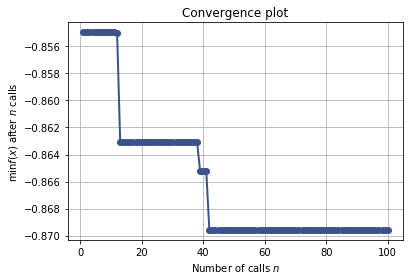

In [10]:
skopt.plots.plot_convergence(skopt_min)
print(f'argmin: {skopt_min.x}')
print(f'f_min: {skopt_min.fun}')

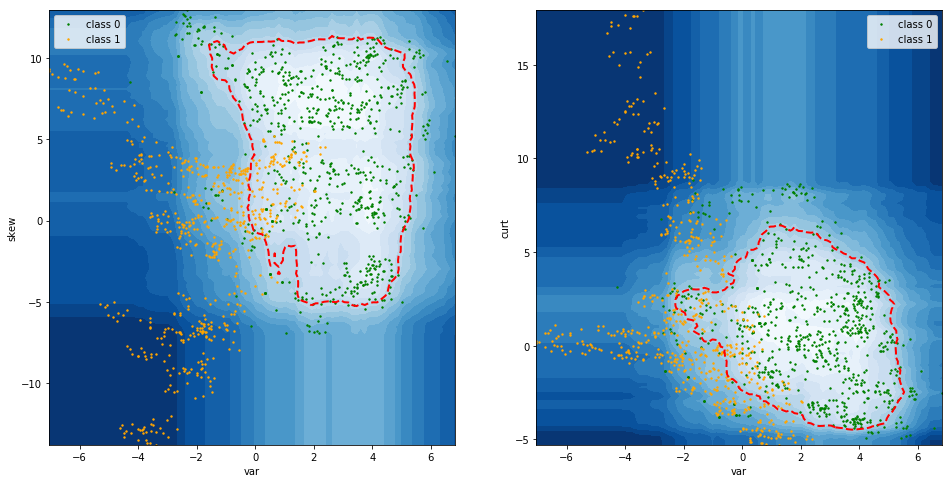

In [11]:
# visualize IsolationTree performance

# outliers_fraction = skopt_min.x[0]
outliers_fraction = 0.185

features = data_no_class.columns
indexed_feature_pairs = [(i-1, features[0], features[i]) for i in range(1, len(features))]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, x_column, y_column in indexed_feature_pairs[:2]:
    isol = IsolationForest(contamination=outliers_fraction, 
                           n_estimators=100,
                           max_features=2)
    
    train_data = data0[[x_column, y_column]]
    isol.fit(train_data)    
    
    ax = axes[i] 
    
    # set axes limits so that all data fits on plot
    xmin, xmax = data[x_column].min(), data[x_column].max()
    ymin, ymax = data[y_column].min(), data[y_column].max()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # prepair mesh for density plots
    n_mesh = 100
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_mesh), np.linspace(ymin, ymax, n_mesh))
    xy = np.c_[xx.ravel(), yy.ravel()]

    score = isol.decision_function(xy)    
    score_grid = score.reshape(xx.shape)
    
    # determine isolation forest score at the decision boundary
    train_data_score = isol.decision_function(train_data)
    score_threshold = np.percentile(train_data_score, 100 * outliers_fraction)
    
    # score density plot
    ax.contourf(xx, yy, score_grid, cmap=plt.cm.Blues_r, 
                levels=list(np.linspace(score.min(), score.max(), 20)))
    # decision boundary plot
    ax.contour(xx, yy, score_grid, levels=[score_threshold], 
               linewidths=2, colors='red', label='threshold')
    
    # class 0 points
    ax.scatter(data0[x_column], data0[y_column], color='g', s=2, label='class 0')
    # class 1 points
    ax.scatter(data1[x_column], data1[y_column], color='orange', s=2, label='class 1')

    ax.set(xlabel=x_column, ylabel=y_column)
    ax.legend()

plt.savefig('isolation_forest_banknotes.png')

# XGBoost

In [4]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

C:\Users\S\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
seed = 7
test_size = 0.33
X = data.iloc[:,:4]
Y = data.iloc[:,4]
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=test_size, random_state=seed) 

In [26]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
                      objective='binary:logistic', nthread=-1, seed=seed)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

In [33]:
ypred = model.predict(testX)
print('PRC Curve {}'.format(metrics.average_precision_score(testY, ypred)))

PRC Curve 0.9915123183529884


In [ ]:
# visualize one of the trees of xgboost forest
graphviz_tree = xgboost.to_graphviz(model)
graphviz_tree.format = 'png'
graphviz_tree.render('xgboost_tree')

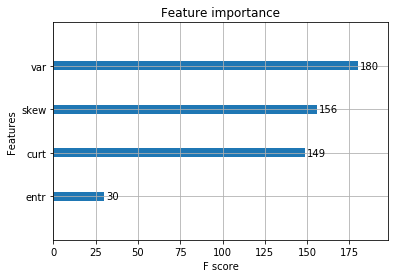

In [10]:
# plor feature importance
xgboost.plot_importance(model)
#plt.savefig('xgboost_feature_importance.png')

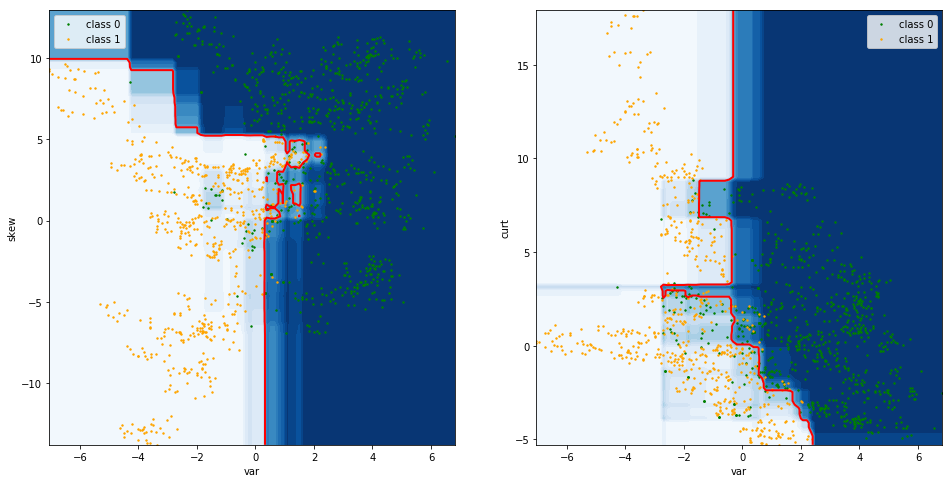

In [30]:
features = data_no_class.columns
indexed_feature_pairs = [(i-1, features[0], features[i]) for i in range(1, len(features))]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, x_column, y_column in indexed_feature_pairs[:2]:
    xgb = XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=200,
                          objective='binary:logistic', nthread=-1, seed=seed)
    
    train_data = data[[x_column, y_column]].values
    xgb.fit(train_data, data['class'].values)    
    
    ax = axes[i] 
    
    # set axes limits so that all data fits on plot
    xmin, xmax = data[x_column].min(), data[x_column].max()
    ymin, ymax = data[y_column].min(), data[y_column].max()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # prepair mesh for density plots
    n_mesh = 100
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_mesh), np.linspace(ymin, ymax, n_mesh))
    xy = np.c_[xx.ravel(), yy.ravel()]

    score = xgb.predict_proba(xy)[:,1]  
    score_grid = score.reshape(xx.shape)
    
    # score density plot
    ax.contourf(xx, yy, score_grid, cmap=plt.cm.Blues_r, 
                levels=list(np.linspace(score.min(), score.max(), 20)))
    # decision boundary plot
    ax.contour(xx, yy, score_grid, levels=[0.5], 
               linewidths=2, colors='red', label='threshold')
    
    # class 0 points
    ax.scatter(data0[x_column], data0[y_column], color='g', s=2, label='class 0')
    # class 1 points
    ax.scatter(data1[x_column], data1[y_column], color='orange', s=2, label='class 1')

    ax.set(xlabel=x_column, ylabel=y_column)
    ax.legend()

plt.savefig('xgboost_banknotes.png')